# Implementing quantum channels in a quantum computer using smaller registers

__Implementation of quantum channels using smaller ancillas (i.e. a smaller quantum register) by factorizing the target quantum channel in Kraus deficient channels__

In this notebook I constructed quantum circuits to simulate two singular quantum channels using a register size smaller than the one dictated by the [__Stinespring theorem__](https://www.quantiki.org/wiki/church-larger-hilbert-space). For qubit channels, the environment 

$$\mathcal{E}[\rho]=\sum_{i=1}^{d^2}{K_i \rho K_i^\dagger{}}$$

<img src="images/circuit.jpeg" width="400" class="center">

## Functions and libraries needed

In [1]:
# Importing libraries for the construction of the quantum circuit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister, execute
# Importing also numpy, will be needed later
import numpy as np
from qiskit.providers.ibmq import least_busy

In [2]:
#Loading account
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [3]:
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
from qiskit.tools.monitor import job_monitor

/tmp/ipykernel_673875/3764712384.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In order to compute how close is the implemented to the theoretical one, we compute the fidelity among them.

In [4]:
#Fidelity
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.states import quantum_state

In [5]:
#Linear Algebra functions
from numpy import dot, trace
from numpy.linalg import matrix_power, multi_dot
from scipy.linalg import sqrtm

In [6]:
#Plotting functions
import matplotlib.pyplot as plt

## Constructing circuits for the implementation of total depolarizing channel

In [11]:
#Define the same uniteries as in the last section just to ilustrate.
U=[[0,0,0,1],
   [0,1,0,0],
   [0,0,1,0],
   [1,0,0,0]
  ]
U2=[[1,0,0,0],
   [0,2**-0.5,2**-0.5,0],
   [0,2**-0.5,-2**-0.5,0],
    [0,0,0,1]
   ]
U3=[[0,0,1,0],
   [2**-0.5,0,0,2**-0.5],
   [-2**-0.5,0,0,2**-0.5],
    [0,1,0,0]
   ]

In [12]:
#Creation of quantum and classical registers and putting them together
q = QuantumRegister(2)
c = ClassicalRegister(1)
qc=QuantumCircuit(q,c)

I define below the unitaries that are going to implement each part of our channel

In [13]:
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.measure(0,0)
qc.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$').c_if(c, 0)
qc.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$').c_if(c, 1)

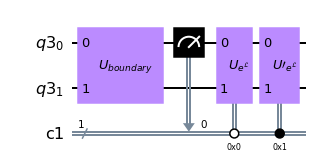

In [14]:
qc.draw('mpl')

_Transpiling_ the circuit so that it can be implemented in the quantum computer. This process is made by IBM anyway.

In [15]:
trans_qc=transpile(qc,basis_gates=['cx','u3','u','cz'],optimization_level=3)

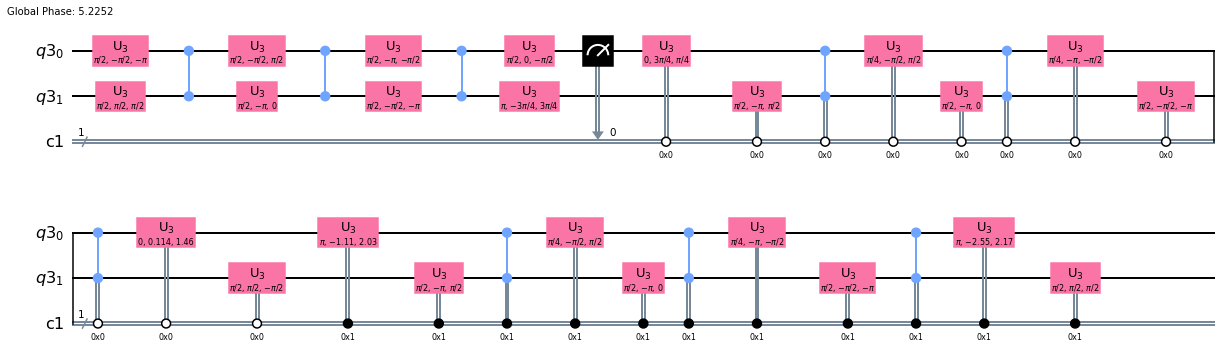

In [16]:
trans_qc.draw('mpl')

### Quantum process tomography

First we start session in IBM Quantum

Quantum process tomography is the procedure to 

In [96]:
backend='ibmq_manila'
quamtum_computer= provider.get_backend(backend)

In [91]:
qpt_circs = process_tomography_circuits(trans_qc,q[1],prepared_qubits=q[1])

In [97]:
job = execute(qpt_circs,backend=quamtum_computer, shots=10000)

job_monitor(job)

Job Status: job incurred error     


In [2]:
# qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

Unfortunately the used IBM 5-qubit computers don not support unitary gates controlled by bits. To overcome this and still prove the concept, we use the principle of [deferred measurement](https://en.wikipedia.org/wiki/Deferred_Measurement_Principle). This is, basically we will use a quantum bit as a classical bit, but to avoid unnecessary operations (for instance a SWAP to always use the same qubit as classical qubit), we simply use the first environmental qubit as a quantum control for the second stage.

# Implementing a singular channel using only the decomposition with 3 qubits

In [7]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.75
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

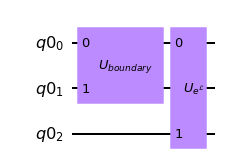

In [8]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
#qc.cnot([1],[2])
qc.unitary(U2,[0,2],label='$U_{e^{\mathcal{L}}}$')
#cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.draw('mpl')

### Quantum process tomography

In [9]:
backend='ibmq_quito'
quamtum_computer= provider.get_backend(backend)

In [10]:
qpt_circs = process_tomography_circuits(qc,q[0],prepared_qubits=q[0])

In [17]:
#joblist2dec=[]
for i in range(2):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist2dec.append(job)

0
Job Status: job has successfully run
1
Job Status: job has successfully run


In [22]:
chois2dec=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist2dec))
chois2dec=list(map(np.array,chois2dec))

In [23]:
len(chois2dec)

10

In [24]:
theoreticalchoi2=np.diag(0.5*np.array([1+l,1-l,1-l,1+l]))

In [56]:
fidelities2dec

[(0.9954003619482998-4.641032297039247e-17j),
 (0.9954523398087629+1.0583556077116377e-16j),
 (0.9954946833967737+8.670254628915249e-18j),
 (0.9945802870424951-2.591866064307436e-18j),
 (0.995786608881142-4.3296638177119495e-18j),
 (0.9957938191980285-5.89964658838384e-17j),
 (0.9951553629686074-1.3882969924388075e-17j),
 (0.9958287428952262+1.735170158520008e-17j),
 (0.9957487234906935-1.3122264250580849e-17j),
 (0.9956884195241263-5.205371523413456e-18j)]

In [25]:
fidelities2dec=[]
for k in chois2dec:
    fidelities2dec.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi2),k,sqrtm(theoreticalchoi2)])))/2)

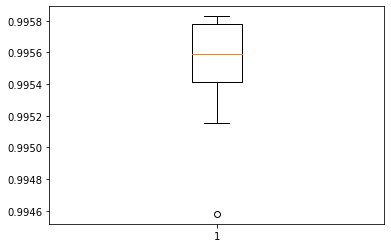

In [26]:
plt.boxplot(np.real(fidelities2dec))
plt.show()

In [30]:
#import csv
#b = open('chois2dec.csv', 'w')
#a = csv.writer(b)
#a.writerows(chois2dec)
#b.close()

# Using deferred measurement example 1

In [439]:
#Define the same uniteries as in the last section just to ilustrate.
U=[[0,0,0,1],
   [0,1,0,0],
   [0,0,1,0],
   [1,0,0,0]
  ]
U2=[[1,0,0,0],
   [0,2**-0.5,2**-0.5,0],
   [0,2**-0.5,-2**-0.5,0],
    [0,0,0,1]
   ]
U3=[[0,0,1,0],
   [2**-0.5,0,0,2**-0.5],
   [-2**-0.5,0,0,2**-0.5],
    [0,1,0,0]
   ]

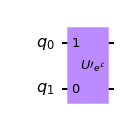

In [440]:
qc1=QuantumCircuit(2)
qc1.unitary(U2,[1,0],'$U_{e^{\mathcal{L}}}$')
qc2=QuantumCircuit(2)
qc2.unitary(U3,[1,0],'$U{\prime}_{e^{\mathcal{L}}}$')
qc2.draw('mpl')

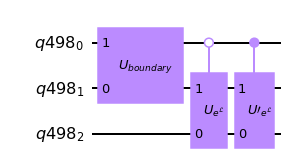

In [441]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[1,0],'$U_{boundary}$')
cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.append(cU1,[0,2,1])
cU1=qc2.to_gate(label='$U{\prime}_{e^{\mathcal{L}}}$').control(1,ctrl_state=1)
qc.append(cU1,[0,2,1])
qc.draw('mpl')
#qc.unitary(U3,[0,1]).c_if(c, 1)

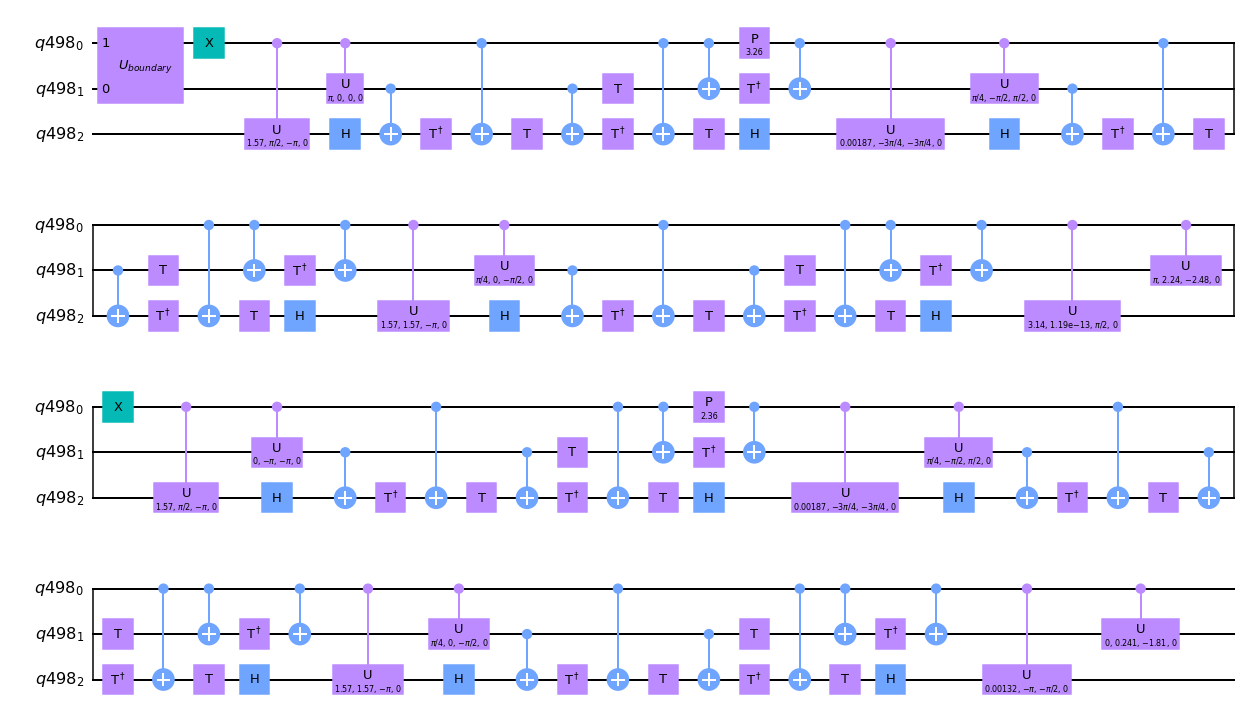

In [443]:
qc_transpiled=transpile(qc,optimization_level=3)
qc_transpiled.draw('mpl')

### Quantum process tomography

In [442]:
backend='ibmq_bogota'
quamtum_computer= provider.get_backend(backend)

In [375]:
qpt_circs = process_tomography_circuits(qc_transpiled,q[1],prepared_qubits=q[1])

In [33]:
# list(map(lambda r: r.draw(),qpt_circs)) Print list of quantum process tomography circuit

In [376]:
job = execute(qpt_circs,backend=quamtum_computer, shots=20000)

In [377]:
job_monitor(job)

Job Status: job has successfully run


In [59]:
#joblist=[]
for i in range(15):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist.append(job)

0
Job Status: job has successfully run
1
Job Status: job has successfully run
2
Job Status: job has successfully run
3
Job Status: job has successfully run
4
Job Status: job has successfully run
5
Job Status: job has successfully run
6
Job Status: job has successfully run
7
Job Status: job has successfully run
8
Job Status: job has successfully run
9
Job Status: job has successfully run
10
Job Status: job has successfully run
11
Job Status: job has successfully run
12
Job Status: job has successfully run
13
Job Status: job has successfully run
14
Job Status: job has successfully run


In [230]:
chois=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist))
chois=list(map(np.array,chois))

In [379]:
choi=ProcessTomographyFitter(job.result(), qpt_circs).fit()

In [378]:
theoreticalchoi=np.diag(0.5*np.array([1,1,1,1]))

In [380]:
trace(sqrtm(multi_dot([sqrtm(theoreticalchoi),choi,sqrtm(theoreticalchoi)])))/2

(0.9892080869797186+3.207282004944268e-17j)

In [395]:
import sympy as sym

In [400]:
import array_to_latex as a2l

$$\begin{bmatrix}
  0.40 + 0.00j &  -0.00 + -0.10j &  0.00 + 0.00j &  -0.00 + 0.10j\\
  -0.00 + 0.10j &  0.60 + 0.00j &  -0.00 + -0.10j &  -0.00 + -0.00j\\
  0.00 + -0.00j &  -0.00 + 0.10j &  0.50 + 0.00j &  0.10 + -0.10j\\
  -0.00 + -0.10j &  -0.00 + 0.00j &  0.10 + 0.10j &  0.50 + 0.00j
\end{bmatrix}$$

In [397]:
choidepo=np.round(choi,1)
choidepo

array([[ 0.4+0.j , -0. -0.1j,  0. +0.j , -0. +0.1j],
       [-0. +0.1j,  0.6+0.j , -0. -0.1j, -0. -0.j ],
       [ 0. -0.j , -0. +0.1j,  0.5+0.j ,  0.1-0.1j],
       [-0. -0.1j, -0. +0.j ,  0.1+0.1j,  0.5+0.j ]])

In [231]:
fidelities=[]
for k in chois:
    fidelities.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi),k,sqrtm(theoreticalchoi)])))/2)

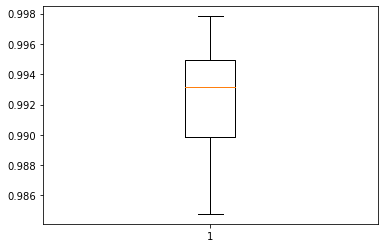

In [232]:
plt.boxplot(np.real(fidelities))
plt.show()

In [233]:
import csv
b = open('fidelities1.csv', 'w')
a = csv.writer(b)
a.writerows(chois)
b.close()

In [235]:
from numpy import genfromtxt
my_data = genfromtxt('fidelities1.csv')

ValueError: Some errors were detected !
    Line #2 (got 9 columns instead of 6)
    Line #3 (got 5 columns instead of 6)
    Line #4 (got 7 columns instead of 6)
    Line #5 (got 3 columns instead of 6)
    Line #8 (got 8 columns instead of 6)
    Line #9 (got 8 columns instead of 6)
    Line #10 (got 3 columns instead of 6)
    Line #12 (got 9 columns instead of 6)
    Line #13 (got 5 columns instead of 6)
    Line #14 (got 7 columns instead of 6)
    Line #15 (got 3 columns instead of 6)
    Line #17 (got 9 columns instead of 6)
    Line #18 (got 5 columns instead of 6)
    Line #19 (got 7 columns instead of 6)
    Line #20 (got 3 columns instead of 6)
    Line #21 (got 3 columns instead of 6)
    Line #23 (got 5 columns instead of 6)
    Line #25 (got 2 columns instead of 6)
    Line #26 (got 7 columns instead of 6)
    Line #27 (got 5 columns instead of 6)
    Line #28 (got 7 columns instead of 6)
    Line #29 (got 7 columns instead of 6)
    Line #30 (got 3 columns instead of 6)
    Line #31 (got 22 columns instead of 6)
    Line #32 (got 7 columns instead of 6)
    Line #33 (got 5 columns instead of 6)
    Line #34 (got 5 columns instead of 6)
    Line #36 (got 3 columns instead of 6)
    Line #37 (got 4 columns instead of 6)
    Line #38 (got 3 columns instead of 6)
    Line #39 (got 3 columns instead of 6)
    Line #40 (got 4 columns instead of 6)
    Line #41 (got 2 columns instead of 6)
    Line #42 (got 7 columns instead of 6)
    Line #43 (got 5 columns instead of 6)
    Line #44 (got 7 columns instead of 6)
    Line #45 (got 7 columns instead of 6)
    Line #46 (got 3 columns instead of 6)
    Line #47 (got 25 columns instead of 6)
    Line #49 (got 5 columns instead of 6)
    Line #50 (got 4 columns instead of 6)
    Line #52 (got 3 columns instead of 6)
    Line #53 (got 4 columns instead of 6)
    Line #54 (got 7 columns instead of 6)
    Line #55 (got 3 columns instead of 6)
    Line #57 (got 3 columns instead of 6)
    Line #58 (got 7 columns instead of 6)
    Line #59 (got 5 columns instead of 6)
    Line #60 (got 7 columns instead of 6)
    Line #61 (got 7 columns instead of 6)
    Line #62 (got 3 columns instead of 6)
    Line #65 (got 4 columns instead of 6)
    Line #67 (got 3 columns instead of 6)
    Line #70 (got 4 columns instead of 6)
    Line #72 (got 3 columns instead of 6)
    Line #74 (got 9 columns instead of 6)
    Line #75 (got 5 columns instead of 6)
    Line #76 (got 7 columns instead of 6)
    Line #77 (got 3 columns instead of 6)
    Line #79 (got 9 columns instead of 6)
    Line #81 (got 7 columns instead of 6)
    Line #82 (got 3 columns instead of 6)
    Line #84 (got 9 columns instead of 6)
    Line #85 (got 5 columns instead of 6)
    Line #86 (got 7 columns instead of 6)
    Line #87 (got 3 columns instead of 6)
    Line #88 (got 28 columns instead of 6)

# Using deferred measurement and effectively using 2 qubits

In [96]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.75
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

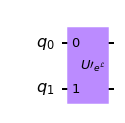

In [97]:
qc1=QuantumCircuit(2)
qc1.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$')
qc2=QuantumCircuit(2)
qc2.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$')
qc2.draw('mpl')

In the following, the third qubit is used as a classical qubit due to the fact that the quantum computer used does not support classically controlled unitary gates.

Therefore, we use a CNOT gate to change the state of the third qubit according to the final environmental state

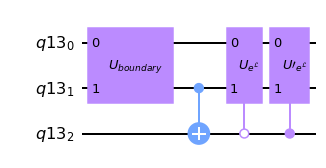

In [98]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.cnot([1],[2])
cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.append(cU1,[2,0,1])
cU2=qc2.to_gate(label='$U{\prime}_{e^{\mathcal{L}}}$').control(1,ctrl_state=1)
qc.append(cU2,[2,0,1])
qc.draw('mpl')
#cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)

### Quantum process tomography

In [99]:
backend='ibmq_quito'
quamtum_computer= provider.get_backend(backend)

In [100]:
qpt_circs = process_tomography_circuits(qc,q[0],prepared_qubits=q[0])

In [70]:
#joblist2=[]
for i in range(8):
    job = execute(qpt_circs,backend=quamtum_computer, shots=20000)
    print(i)
    job_monitor(job)
    joblist2.append(job)

0
Job Status: job has successfully run
1
Job Status: job has successfully run
2
Job Status: job has successfully run
3
Job Status: job has successfully run
4
Job Status: job has successfully run
5
Job Status: job has successfully run
6
Job Status: job has successfully run
7
Job Status: job has successfully run


In [71]:
chois2=list(map(lambda r: ProcessTomographyFitter(r.result(), qpt_circs).fit(),joblist2))
chois2=list(map(np.array,chois2))

In [88]:
np.round(chois2[6],1)

array([[ 0.7+0.j ,  0.1-0.j , -0. -0.1j,  0.1-0.1j],
       [ 0.1+0.j ,  0.3+0.j , -0.1+0.j ,  0. +0.1j],
       [-0. +0.1j, -0.1-0.j ,  0.4+0.j , -0.1+0.j ],
       [ 0.1+0.1j,  0. -0.1j, -0.1-0.j ,  0.6+0.j ]])

In [76]:
fidelities2=[]
for k in chois2:
    fidelities2.append(trace(sqrtm(multi_dot([sqrtm(theoreticalchoi2),k,sqrtm(theoreticalchoi2)])))/2)

In [106]:
fidelities2

[(0.9544422808207389-7.046657428755168e-17j),
 (0.9593930862438218-2.542496679416495e-17j),
 (0.9531955748386332-2.0833472515479572e-17j),
 (0.9564431817561061-4.503203667665078e-17j),
 (0.9583185038854869-5.814832086018091e-17j),
 (0.9581180414039011+3.4568061475891347e-18j),
 (0.9576835755033482-4.8574082328344235e-17j),
 (0.9474204357735959-1.0437675611359956e-17j),
 (0.9674169551363101-3.4826221790063944e-17j),
 (0.9538350083651695+1.831819130351159e-17j)]

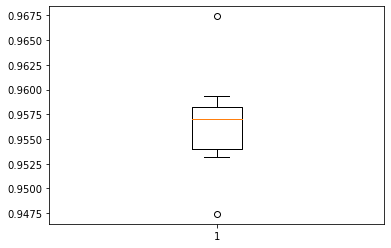

In [77]:
plt.boxplot(np.real(fidelities2))
plt.show()

In [113]:
np.save('chois2.npy', np.array(chois2),allow_pickle=False)

In [108]:
np.save('chois2.npy', chois2, allow_pickle=True)
testchois2 = np.load('chois.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'chois.npy'

In [107]:
import csv
b = open('chois2.csv', 'w')
a = csv.writer(b)
a.writerows(chois2)
b.close()